# Typical architecture of a classification neural network 

The word *typical* is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An input layer.
* Some hidden layers.
* An output layer.

Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

***Table 1:*** *Typical architecture of a classification network.* ***Source:*** *Adapted from page 295 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

[epub](http://library.lol/main/E585D7EA43B3477E96A53A0BC1220F37)

[pdf](http://library.lol/main/40CA3F6E08498377145117D8B48BFD1B)

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [1]:
import tensorflow as tf
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from tensorflow.keras.models import Sequential  # Model type to be used
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Dropout, Activation
from tensorflow.keras.datasets import mnist     # MNIST dataset is included in Keras
from tensorflow.keras.utils import to_categorical, plot_model

print(tf.__version__) # find the version number (should be 2.x+)

# 그래피카드 유무 확인 및 메모리 확장 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print('사용가능한 GPU 갯수: ',len(gpus), '\n')
      
  try:
    # 프로그램이 실행되어 더 많은 GPU 메모리가 필요하면, 텐서플로 프로세스에 할당된 GPU 메모리 
    # 영역을 확장할 수있도록 허용
    tf.config.experimental.set_memory_growth(gpus[0], True)

  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

# 설치된 GPU 상세내용 확인
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.5.0
사용가능한 GPU 갯수:  1 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11219130335789744603
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16183459840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10775898239064897859
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [222]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' >

In [223]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


We then modify our classes (unique digits) to be in the **one-hot format**, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [224]:
nb_classes = 10 # number of unique digits

Y_train = to_categorical(y_train,nb_classes)
Y_test = to_categorical(y_test,nb_classes)

# Building a 3-layer fully connected network (FCN)

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

## A DNN Model

In [5]:
# The Sequential model is a linear stack of layers and is very common.

model = Sequential()

# The first hidden layer is a set of 512 nodes (artificial neurons).
# Each node will receive an element from each input vector and apply some weight and bias to it.

model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!
model.add(Activation('relu')) # # An "activation" is a non-linear function applied to the output of the layer.
                              # The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
                              # Those inputs are then not considered to be fired.
                              # Positive values of a node are unchanged.
model.add(Dropout(0.2)) # Dropout zeroes a selection of random outputs (i.e., disables their activation)
                        # Dropout helps protect the model from memorizing or "overfitting" the training data.

# The second hidden layer appears identical to our first layer.
# However, instead of each of the 512-node receiving 784-inputs from the input image data,
# they receive 512 inputs from the output of the first 512-node layer.

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# The final layer of 10 neurons in fully-connected to the previous 512-node layer.
# The final layer of a FCN should be equal to the number of desired classes (10 in this case).
model.add(Dense(10))
model.add(Activation('softmax')) # The "softmax" activation represents a probability distribution over K different possible outcomes.
                                 # Its values are all non-negative and sum to 1.

In [6]:
# Summarize the built model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5

## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

<img src = "https://randlow.github.io/images/ml/gradient-descent.png" >

<img src = "https://srdas.github.io/DLBook/DL_images/TNN2.png" >

So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.

<img src = 'https://miro.medium.com/max/2060/1*9DVEXY4X0eNAx_ZHoD_PPA.png' >

In [7]:
# Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model!
This is the fun part! 

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So **a good batch size may take some trial and error to find!**

In [8]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=5,
           validation_data=(X_test, Y_test), verbose=1)

Epoch 1/5
469/469 [==============================] - 4s 4ms/step - loss: 0.2510 - accuracy: 0.9247 - val_loss: 0.1031 - val_accuracy: 0.9680
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0994 - accuracy: 0.9695 - val_loss: 0.0854 - val_accuracy: 0.9738
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0724 - accuracy: 0.9772 - val_loss: 0.0765 - val_accuracy: 0.9762
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0562 - accuracy: 0.9820 - val_loss: 0.0717 - val_accuracy: 0.9775
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0434 - accuracy: 0.9857 - val_loss: 0.0649 - val_accuracy: 0.9806


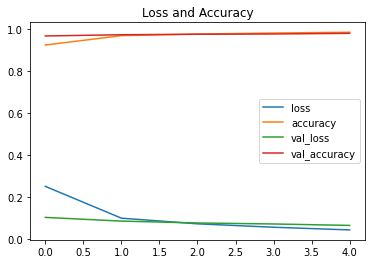

In [9]:
import pandas as pd
pd.DataFrame(history.history).plot(title="Loss and Accuracy")

The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data



### 분류성능평가지표 - 혼동행렬(Confusion Matrix)

모델을 평가하는 요소는 결국, 모델이 내놓은 답과 실제 정답의 관계로써 정의를 내릴 수 있습니다. 정답이 True와 False로 나누어져있고, 분류 모델 또한 True False의 답을 내놓습니다. 그렇게 하면, 이진분류(Binary Classification)의 경우 아래와 같이 2x2 matrix로 case를 나누어볼 수 있습니다.

<img src="https://t1.daumcdn.net/cfile/tistory/99DC064C5BE056CE10">

위와 같이 구분한 표를 혼동행렬(Confusion Matrix)이라고 합니다
```
  - True Positive(TP) : 실제 True인 정답을 True라고 예측 (정답)
  - False Positive(FP) : 실제 False인 정답을 True라고 예측 (오답)
  - False Negative(FN) : 실제 True인 정답을 False라고 예측 (오답)
  - True Negative(TN) : 실제 False인 정답을 False라고 예측 (정답)
```


###  분류성능평가지표 - Precision(정밀도)과 Recall(재현율)

  - Precision(정밀도): 모델이 True라고 분류한 것 중에서 실제 True인 것의 비율

    $$Precision =  \frac {TP}{TP+FP}$$

  - Recall(재현율): 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율

    $$Recall =  \frac {TP}{TP+FN}$$

    통계학에서는 sensitivity로, 그리고 다른 분야에서는 hit rate라는 용어로도 사용합니다. 실제 날씨가 맑은 날 중에서 모델이 맑다고 예측한 비율을 나타낸 지표인데, 정밀도(Precision)와 True Positive의 경우를 다르게 바라보는 것입니다. 즉, Precision이나 Recall은 모두 실제 True인 정답을 모델이 True라고 예측한 경우에 관심이 있으나, 바라보고자 하는 관점만 다릅니다. Precision은 모델의 입장에서, 그리고 Recall은 실제 정답(data)의 입장에서 정답을 정답이라고 맞춘 경우를 바라보고 있습니다. 

      <img src= "https://t1.daumcdn.net/cfile/tistory/999D9C465BE116E43C">

  A는 실제 날씨가 맑은 날입니다. 그리고 B는 모델에서 날씨가 맑은 날이라고 예측한 것입니다.
  $$Precison =\frac{b}{b+c},  \hspace{2ex}  Recall = \frac{b}{a+b}$$

  모델의 입장에서 모두 맑은 날이라고만 예측하는 경우를 생각해봅시다. 그렇게 되면 TN(d)의 영역이 줄어들게 되고 그에 따라 FN(a)의 영역 또한 줄게 됩니다. 그러므로 Recall은 분모의 일부인 FN(a)영역이 줄기 때문에 Recall은 100%가 됩니다. 

    <img src = "https://t1.daumcdn.net/cfile/tistory/9951F44B5BE1205F1E">

  위 그림의 왼쪽 Case에서 Recall은 20 / 50 = 40%, Precision = 20 / 60 = 33.3% 입니다. 그리고 분류모델이 모두 True라고 예측한 오른쪽의 case에서의 recall은 FN = 0이므로 100%이지만 그에 따라 FP가 늘어서 precision은 20/100 = 20%가 되었습니다. 이처럼 precision과 recall은 모두 높은 것이 좋지만, trade-off 관계에 있어서 함께 늘리기가 힘듭니다.

 Precision과 Recall은 trade-off관계이며 상호보완적으로 해석해야하며, 두 지표가 모두 높을 수록 좋은 모델입니다.


  - Recall(재현율): 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율

    $$Recall =  \frac {TP}{TP+FN}$$

    통계학에서는 sensitivity로, 그리고 다른 분야에서는 hit rate라는 용어로도 사용합니다. 실제 날씨가 맑은 날 중에서 모델이 맑다고 예측한 비율을 나타낸 지표인데, 정밀도(Precision)와 True Positive의 경우를 다르게 바라보는 것입니다. 즉, Precision이나 Recall은 모두 실제 True인 정답을 모델이 True라고 예측한 경우에 관심이 있으나, 바라보고자 하는 관점만 다릅니다. Precision은 모델의 입장에서, 그리고 Recall은 실제 정답(data)의 입장에서 정답을 정답이라고 맞춘 경우를 바라보고 있습니다. 




###  분류성능평가지표 - Accuracy(정확도) 와 F1 Score

  - Accuracy(정확도)

  $$Accuracy(정확도) = \frac {TP + TN}{TP+FN+FP+FN}$$

  앞서 설명한 두 지표는 모두 True를 True라고 옳게 예측한 경우에 대해서만 다루었습니다. 하지만, False를 False라고 예측한 경우도 옳은 경우입니다. 이때, 해당 경우를 고려하는 지표가 바로 정확도(Accuracy)입니다. 

  정확도는 **가장 직관적으로 모델의 성능을 나타낼 수 있는 평가 지표**입니다. 
  
  하지만, 여기서 고려해야하는 것이 있습니다. 바로 domain의 편중(bias)입니다. 만약 우리가 예측하고자 하는 한달 동안이 특정 기후에 부합하여 비오는 날이 흔치 않다고 생각해보죠. 이 경우에는 해당 data의 domain이 불균형하게되므로 맑은 것을 예측하는 성능은 높지만, 비가 오는 것을 예측하는 성능은 매우 낮을 수 밖에 없습니다. 따라서 이를 보완할 지표가 필요합니다.

  - F1 Score: Precision과 Recall의 [조화평균(역수의 산술 평균의 역수)](https://ko.wikipedia.org/wiki/%EC%A1%B0%ED%99%94_%ED%8F%89%EA%B7%A0)입니다. 

 $$F1  = 2 \times \frac {1}{\frac{1}{Precision} + \frac{1}{recall}}  = 2 \times \frac{Precision \times Recall}{Precision+Recall}$$ 





| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) or [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) or [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | Custom function or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |



Let's start with accuracy.

Because we passed `["accuracy"]` to the `metrics` parameter when we compiled our model, calling `evaluate()` on it will return the loss as well as accuracy.


In [10]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test score:', loss)
print('Test accuracy:', accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.0649 - accuracy: 0.9806
Test score: 0.06491013616323471
Test accuracy: 0.9805999994277954


In [11]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_TF_Multilayer_Perceptrons.ipynb
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [12]:
# Get predicted class for X_test by converting all of the predictions from probabilities to labels
y_probs = model.predict(X_test)
#print(tf.argmax(pred[0:10]))
print(y_probs[0:10])

y_pred=y_probs.argmax(axis=1)
print(y_pred[0:10])
print(y_test[0:10])

[[6.74815037e-10 3.23712825e-08 6.58963984e-07 3.55742827e-07
  1.45615894e-10 1.31969746e-09 3.52314179e-13 9.99998450e-01
  1.11946374e-09 4.27004579e-07]
 [2.08565526e-11 1.23450343e-06 9.99998450e-01 1.25350439e-07
  7.88194041e-14 1.07650799e-09 7.83497399e-12 1.68578380e-11
  2.48006955e-07 3.14809398e-12]
 [1.92544309e-08 9.99951601e-01 3.09650454e-06 7.89006407e-08
  1.38363521e-05 2.22989229e-06 2.69446218e-06 1.31966981e-05
  1.31694023e-05 8.08907288e-08]
 [9.99897480e-01 4.61010181e-08 4.17591109e-05 3.10228074e-08
  3.80495067e-06 9.23004464e-08 4.78500842e-05 2.06056620e-06
  6.35196429e-09 6.93826087e-06]
 [6.64871607e-08 1.85288670e-07 5.87458430e-07 1.82098803e-09
  9.99871731e-01 1.45743527e-07 7.60872894e-08 1.43009072e-06
  4.09392875e-08 1.25690742e-04]
 [6.29400976e-11 9.99996662e-01 2.26950703e-09 1.62219627e-10
  5.88660328e-07 1.75843162e-09 1.15307563e-09 2.79741153e-06
  2.97561993e-08 4.60840255e-09]
 [1.16518937e-08 1.95590860e-06 1.94256859e-08 1.37888065e

In [134]:
# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, 
                 y_pred=y_pred)
df = pd.DataFrame(cm)
df['sum']=df.sum(axis=1)
df.loc['Total']= df.sum()
df

,0,1,2,3,4,5,6,7,8,9,sum
0,969,1,1,1,1,1,4,1,1,0,980
1,0,1130,1,1,0,1,1,0,1,0,1135
2,0,0,1018,3,1,0,2,5,3,0,1032
3,0,0,2,995,0,4,0,4,2,3,1010
4,0,2,3,0,967,0,6,1,0,3,982
5,2,0,0,8,1,878,2,0,0,1,892
6,1,2,1,0,1,11,939,0,3,0,958
7,0,5,11,2,2,1,0,998,3,6,1028
8,3,1,3,15,1,7,0,5,938,1,974
9,1,5,0,9,13,4,0,1,2,974,1009


That confusion matrix is hard to comprehend, let's make it prettier using the function we created before.

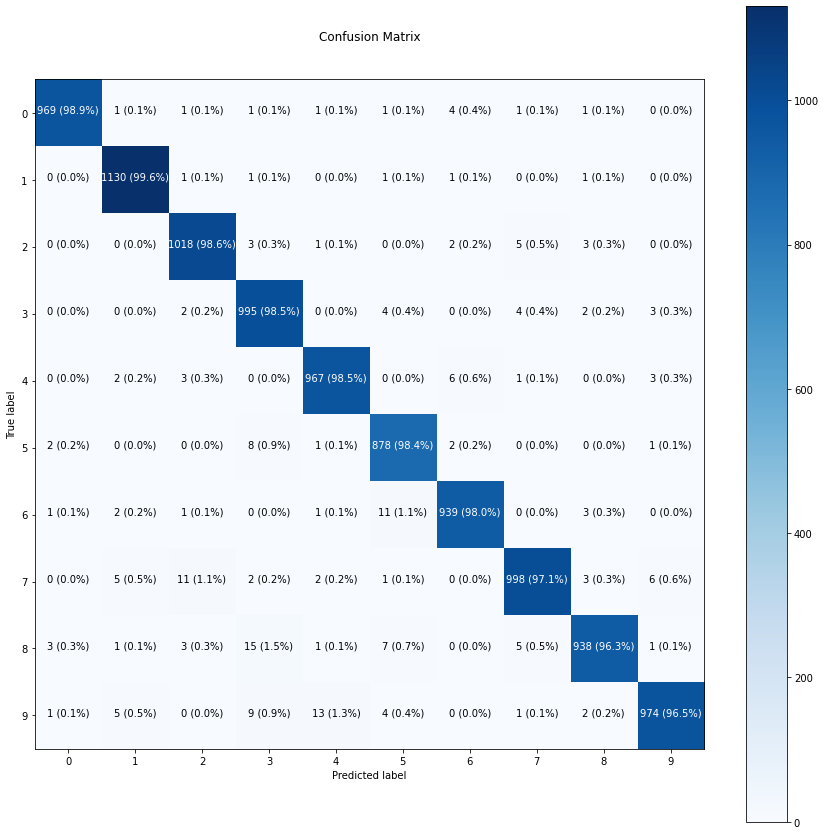

In [14]:
# Make a prettier confusion matrix

class_names=[str(i) for i in range(0,10)]
make_confusion_matrix(y_true=y_test, 
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [51]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]


incorrect_indices.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(194,)

### Visualize FN

In [225]:
# 앞서데이터 전처리과정에서에서 우리는 28 by 28 이차원 이미지데이터 1차원 벡터로 Reshape 시켜놓았다. 
# 이미지 플로팅을 위해 우리는 다시 이미지를 이차원으로 변화 시킨다.

x_test = X_test.reshape(10000, 28,28) 

In [228]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot FN classified images

def show_FN(x_test,y_test, y_pred, true_class):

  dict = {'True Class': y_test,'Predicted Class':y_pred}
  df = pd.DataFrame(dict)
  df['row_num'] = df.index
  df = df[df['True Class']==true_class]
  df = df[df['True Class'] != df['Predicted Class']]
  n = df.shape[0] # sample size
  print("Total Rows = ",n)
  print(df)

  subplots_adjust(hspace=0.500)
  plt.figure(figsize=(10, 10))

  rows = 5 if n <= 25 else 6 
  for i in range(n):
    ax = plt.subplot(rows, rows, i + 1)
    plt.imshow(x_test[df.iat[i,2]], cmap='gray')
    plt.title("True: {} Pred: {} ".format(df.iat[i,0],df.iat[i,1]))
    plt.axis(False)

Total Rows =  14
      True Class  Predicted Class  row_num
340            5                3      340
951            5                4      951
1393           5                3     1393
1970           5                3     1970
2035           5                3     2035
2597           5                3     2597
3117           5                9     3117
3558           5                0     3558
3893           5                6     3893
5937           5                3     5937
5972           5                3     5972
9422           5                3     9422
9729           5                6     9729
9770           5                0     9770


<Figure size 432x288 with 0 Axes>

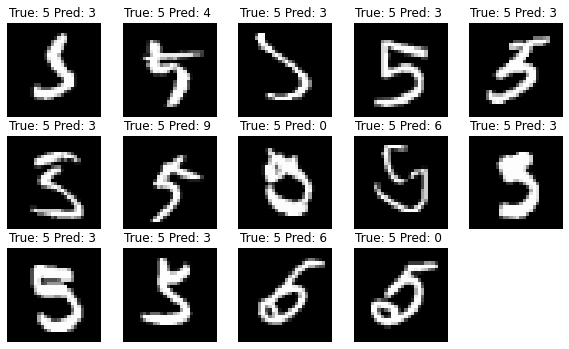

In [229]:
show_FN(x_test,y_test, y_pred,5 )

### Visualize FP

Total Rows =  15
      True Class  Predicted Class  row_num
610            4                6      610
1112           4                6     1112
1549           4                6     1549
1609           2                6     1609
1621           0                6     1621
3780           4                6     3780
3893           5                6     3893
3941           4                6     3941
4477           0                6     4477
4751           4                6     4751
6574           2                6     6574
6783           1                6     6783
7216           0                6     7216
8325           0                6     8325
9729           5                6     9729


<Figure size 432x288 with 0 Axes>

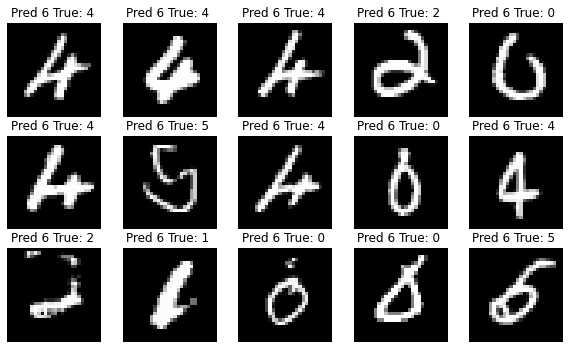

In [239]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot FP classified images

def show_FP(x_test,y_test, y_pred, pred_class):

  dict = {'True Class': y_test,'Predicted Class':y_pred}
  df = pd.DataFrame(dict)
  df['row_num'] = df.index
  df = df[df['Predicted Class']==pred_class]
  df = df[df['True Class'] != df['Predicted Class']]
  n = df.shape[0] # sample size
  print("Total Rows = ",n)
  print(df)

  subplots_adjust(hspace=0.500)
  plt.figure(figsize=(10, 10))

  rows = 5 if n <= 25 else 6 
  for i in range(n):
    ax = plt.subplot(rows, rows, i + 1)
    plt.imshow(x_test[df.iat[i,2]], cmap='gray')
    plt.title("Pred {} True: {} ".format(df.iat[i,1],df.iat[i,0]))
    plt.axis(False)

show_FP(x_test,y_test, y_pred, 6)